## Drug Discover Pipeline of Mglur1

In [1]:
import logging

from collections import Counter
from operator import itemgetter
from lxml import etree

from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools, Lipinski
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover
from IPython.display import Image, display
import pandas as pd
import json
import sys
from log_progress import *
from chembl_webresource_client.settings import Settings
from chembl_webresource_client.new_client import new_client
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import pubchempy as pcp
from IPython.display import HTML
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from scipy.stats import mannwhitneyu 
from sklearn.model_selection import train_test_split
%matplotlib inline

ModuleNotFoundError: No module named 'sweetviz'

## Target Identifcation done in CHEMBL and get know compounds of intrest

In [2]:
chembl_id = "CHEMBL3772"

In [3]:
records = new_client.activity.filter(target_chembl_id=chembl_id)

len(records)

2295

In [4]:
# Target Search
target = new_client.target
target_query = target.search('CHEMBL3772')
targets = pd.DataFrame.from_dict(target_query)
targets[:10]
# Assigning the selected target as entry 1
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL3772'

# Only Instrested in compounds with bioactivity value IC50 to distingusigh compounds between active and inactive compounds for generating a prediction algorithm to test other data for SAR relationship

In [5]:
activity = new_client.activity
result = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [6]:
# Converting dictionary to dataframe
df = pd.DataFrame.from_dict(result)
df.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,No effect,75841,[],CHEMBL879744,Inhibition of Quisqualate-Induced PI Hydrolysi...,F,None,None,BAO_0000190,BAO_0000019,...,Homo sapiens,Metabotropic glutamate receptor 1,9606,None,None,IC50,uM,None,None,None
1,None,80386,[],CHEMBL710045,Inhibition of Quisqualate-Induced PI Hydrolysi...,F,None,None,BAO_0000190,BAO_0000019,...,Homo sapiens,Metabotropic glutamate receptor 1,9606,None,None,IC50,uM,UO_0000065,None,0.43
2,Not Active,82589,[],CHEMBL710046,Inhibition of Quisqualate-Induced PI Hydrolysi...,F,None,None,BAO_0000190,BAO_0000019,...,Homo sapiens,Metabotropic glutamate receptor 1,9606,None,None,IC50,uM,None,None,None


In [7]:
# Getting the shape of the dataframe created
df.shape
# Saving the dataframe to a csv file
df.to_csv('Target_data_raw.csv',index=False)

In [8]:
df1 = df[df.value.notna()] #cleaning the data
df2 = df1[df1.canonical_smiles.notna()] #removing the data without smiles.
df2.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
1,None,80386,[],CHEMBL710045,Inhibition of Quisqualate-Induced PI Hydrolysi...,F,None,None,BAO_0000190,BAO_0000019,...,Homo sapiens,Metabotropic glutamate receptor 1,9606,None,None,IC50,uM,UO_0000065,None,0.43
4,None,93635,[],CHEMBL710045,Inhibition of Quisqualate-Induced PI Hydrolysi...,F,None,None,BAO_0000190,BAO_0000019,...,Homo sapiens,Metabotropic glutamate receptor 1,9606,None,None,IC50,uM,UO_0000065,None,1.2
5,None,99554,[],CHEMBL710045,Inhibition of Quisqualate-Induced PI Hydrolysi...,F,None,None,BAO_0000190,BAO_0000019,...,Homo sapiens,Metabotropic glutamate receptor 1,9606,None,None,IC50,uM,UO_0000065,None,1.5


In [9]:
# Dropping the duplicates
df3 = df2.drop_duplicates(['canonical_smiles'])
df3.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
1,None,80386,[],CHEMBL710045,Inhibition of Quisqualate-Induced PI Hydrolysi...,F,None,None,BAO_0000190,BAO_0000019,...,Homo sapiens,Metabotropic glutamate receptor 1,9606,None,None,IC50,uM,UO_0000065,None,0.43
4,None,93635,[],CHEMBL710045,Inhibition of Quisqualate-Induced PI Hydrolysi...,F,None,None,BAO_0000190,BAO_0000019,...,Homo sapiens,Metabotropic glutamate receptor 1,9606,None,None,IC50,uM,UO_0000065,None,1.2
5,None,99554,[],CHEMBL710045,Inhibition of Quisqualate-Induced PI Hydrolysi...,F,None,None,BAO_0000190,BAO_0000019,...,Homo sapiens,Metabotropic glutamate receptor 1,9606,None,None,IC50,uM,UO_0000065,None,1.5


In [10]:
# Classifying compounds by labeling into active, intermediate and inactive
bioactivity_class = []
for i in df3.standard_value:
  if float(i) >= 10000.0:
    bioactivity_class.append('inactive')
  elif float(i) <= 1000.0:
    bioactivity_class.append('active')
  else:
    bioactivity_class.append('intermediate')

In [11]:
# Combining the columns molecule_chembl_id,canonical_smiles,standard_value
columns = ['molecule_chembl_id','canonical_smiles','standard_value']
df4 = df3[columns]
df4[10:50]

,molecule_chembl_id,canonical_smiles,standard_value
13,CHEMBL94990,N[C@H](C(=O)O)c1ccc(C(=O)O)cc1,65000.0
17,CHEMBL328984,NC(C(=O)O)c1ccc(C(=O)O)cc1,65000.0
19,CHEMBL444589,NC(C(=O)O)c1ccc(C(=O)O)c(O)c1,40000.0
20,CHEMBL39338,N[C@@H](C[C@H](CCCC(c1ccccc1)c1ccccc1)C(=O)O)C...,300000.0
21,CHEMBL40123,N[C@@H](C[C@H](CC(c1ccccc1)c1ccccc1)C(=O)O)C(=O)O,300000.0
22,CHEMBL97574,C[C@@H]1[C@H](C(=O)O)[C@H]1C(N)(CC1c2ccccc2Oc2...,100000.0
23,CHEMBL420262,CCCCCCCCC[C@@H]1[C@H](C(=O)O)[C@H]1C(N)(CC1c2c...,5700.0
24,CHEMBL319279,NC(CC1c2ccccc2Oc2ccccc21)(C(=O)O)[C@H]1[C@H](C...,100000.0
25,CHEMBL439775,CC[C@@H]1[C@H](C(=O)O)[C@H]1C(N)(CC1c2ccccc2Oc...,100000.0
26,CHEMBL99462,CCC[C@@H]1[C@H](C(=O)O)[C@H]1C(N)(CC1c2ccccc2O...,100000.0


In [12]:
# Concatenating the bioactivity_class column
df4['class'] = bioactivity_class
df4

/tmp/ipykernel_2457253/3172209521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['class'] = bioactivity_class


,molecule_chembl_id,canonical_smiles,standard_value,class
1,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,430.0,active
4,CHEMBL138082,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,1200.0,intermediate
5,CHEMBL2111945,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,1500.0,intermediate
6,CHEMBL434064,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...,1400.0,intermediate
7,CHEMBL327783,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2,3400.0,intermediate
...,...,...,...,...
1023,CHEMBL4445682,COc1cc(C(=O)Nc2cc(OC(F)(F)F)ccc2-n2cncn2)ccc1O...,10000.0,inactive
1024,CHEMBL3892073,NC(=O)c1cc(-c2ccc(F)cc2)c2ccc(CN3C(=O)CCC3=O)c...,10000.0,inactive
1025,CHEMBL1527295,CCOC(=O)c1cnc2c(OC)cccc2c1N1CCN(c2ccccc2F)CC1,30000.0,inactive
1026,CHEMBL334014,N[C@@]1(C(=O)O)[C@@H](F)C[C@H]2[C@H](C(=O)O)[C...,30000.0,inactive


In [13]:
# Saving the dataframe to csv
df4.to_csv('Target_data_preprocessed.csv',index=False)

In [14]:
# Reading the csv file into DataFrame
df = pd.read_csv('Target_data_preprocessed.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,430.0,active
1,CHEMBL138082,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,1200.0,intermediate
2,CHEMBL2111945,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,1500.0,intermediate
3,CHEMBL434064,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...,1400.0,intermediate
4,CHEMBL327783,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2,3400.0,intermediate
...,...,...,...,...
844,CHEMBL4445682,COc1cc(C(=O)Nc2cc(OC(F)(F)F)ccc2-n2cncn2)ccc1O...,10000.0,inactive
845,CHEMBL3892073,NC(=O)c1cc(-c2ccc(F)cc2)c2ccc(CN3C(=O)CCC3=O)c...,10000.0,inactive
846,CHEMBL1527295,CCOC(=O)c1cnc2c(OC)cccc2c1N1CCN(c2ccccc2F)CC1,30000.0,inactive
847,CHEMBL334014,N[C@@]1(C(=O)O)[C@@H](F)C[C@H]2[C@H](C(=O)O)[C...,30000.0,inactive


In [15]:
# Importing the necessary libraries
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [16]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [17]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [18]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL2111944,430.0,active,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...
1,CHEMBL138082,1200.0,intermediate,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...
2,CHEMBL2111945,1500.0,intermediate,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2
3,CHEMBL434064,1400.0,intermediate,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...
4,CHEMBL327783,3400.0,intermediate,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2
...,...,...,...,...
844,CHEMBL4445682,10000.0,inactive,COc1cc(C(=O)Nc2cc(OC(F)(F)F)ccc2-n2cncn2)ccc1O...
845,CHEMBL3892073,10000.0,inactive,NC(=O)c1cc(-c2ccc(F)cc2)c2ccc(CN3C(=O)CCC3=O)c...
846,CHEMBL1527295,30000.0,inactive,CCOC(=O)c1cnc2c(OC)cccc2c1N1CCN(c2ccccc2F)CC1
847,CHEMBL334014,30000.0,inactive,N[C@@]1(C(=O)O)[C@@H](F)C[C@H]2[C@H](C(=O)O)[C...


In [19]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [20]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,380.400,1.9165,2.0,6.0
1,380.400,1.9165,2.0,6.0
2,247.250,1.5791,1.0,5.0
3,380.400,1.9165,2.0,6.0
4,247.250,1.5791,1.0,5.0
...,...,...,...,...
844,448.401,4.2156,1.0,7.0
845,377.375,2.7888,1.0,4.0
846,409.461,3.8858,0.0,6.0
847,203.169,-0.5429,3.0,3.0


In [21]:
# Dataframe 1
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,380.400,1.9165,2.0,6.0
1,380.400,1.9165,2.0,6.0
2,247.250,1.5791,1.0,5.0
3,380.400,1.9165,2.0,6.0
4,247.250,1.5791,1.0,5.0
...,...,...,...,...
844,448.401,4.2156,1.0,7.0
845,377.375,2.7888,1.0,4.0
846,409.461,3.8858,0.0,6.0
847,203.169,-0.5429,3.0,3.0


In [22]:
# Dataframe 2
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,430.0,active
1,CHEMBL138082,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,1200.0,intermediate
2,CHEMBL2111945,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,1500.0,intermediate
3,CHEMBL434064,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...,1400.0,intermediate
4,CHEMBL327783,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2,3400.0,intermediate
...,...,...,...,...
844,CHEMBL4445682,COc1cc(C(=O)Nc2cc(OC(F)(F)F)ccc2-n2cncn2)ccc1O...,10000.0,inactive
845,CHEMBL3892073,NC(=O)c1cc(-c2ccc(F)cc2)c2ccc(CN3C(=O)CCC3=O)c...,10000.0,inactive
846,CHEMBL1527295,CCOC(=O)c1cnc2c(OC)cccc2c1N1CCN(c2ccccc2F)CC1,30000.0,inactive
847,CHEMBL334014,N[C@@]1(C(=O)O)[C@@H](F)C[C@H]2[C@H](C(=O)O)[C...,30000.0,inactive


In [23]:
# Combining the two columns
df_combined = pd.concat([df,df_lipinski],axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,430.0,active,380.400,1.9165,2.0,6.0
1,CHEMBL138082,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,1200.0,intermediate,380.400,1.9165,2.0,6.0
2,CHEMBL2111945,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,1500.0,intermediate,247.250,1.5791,1.0,5.0
3,CHEMBL434064,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...,1400.0,intermediate,380.400,1.9165,2.0,6.0
4,CHEMBL327783,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2,3400.0,intermediate,247.250,1.5791,1.0,5.0
...,...,...,...,...,...,...,...,...
844,CHEMBL4445682,COc1cc(C(=O)Nc2cc(OC(F)(F)F)ccc2-n2cncn2)ccc1O...,10000.0,inactive,448.401,4.2156,1.0,7.0
845,CHEMBL3892073,NC(=O)c1cc(-c2ccc(F)cc2)c2ccc(CN3C(=O)CCC3=O)c...,10000.0,inactive,377.375,2.7888,1.0,4.0
846,CHEMBL1527295,CCOC(=O)c1cnc2c(OC)cccc2c1N1CCN(c2ccccc2F)CC1,30000.0,inactive,409.461,3.8858,0.0,6.0
847,CHEMBL334014,N[C@@]1(C(=O)O)[C@@H](F)C[C@H]2[C@H](C(=O)O)[C...,30000.0,inactive,203.169,-0.5429,3.0,3.0


In [24]:
# Saving this to csv file
df_combined.to_csv('Target_combined_dataframe.csv',index=False)

,molecule_chembl_id,ROMol,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL2111944,,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,430.0,active,380.400,1.9165,2.0,6.0
1,CHEMBL138082,,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,1200.0,intermediate,380.400,1.9165,2.0,6.0
2,CHEMBL2111945,,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,1500.0,intermediate,247.250,1.5791,1.0,5.0
3,CHEMBL434064,,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...,1400.0,intermediate,380.400,1.9165,2.0,6.0
4,CHEMBL327783,,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2,3400.0,intermediate,247.250,1.5791,1.0,5.0
...,...,...,...,...,...,...,...,...,...
844,CHEMBL4445682,,COc1cc(C(=O)Nc2cc(OC(F)(F)F)ccc2-n2cncn2)ccc1O...,10000.0,inactive,448.401,4.2156,1.0,7.0
845,CHEMBL3892073,,NC(=O)c1cc(-c2ccc(F)cc2)c2ccc(CN3C(=O)CCC3=O)c...,10000.0,inactive,377.375,2.7888,1.0,4.0
846,CHEMBL1527295,,CCOC(=O)c1cnc2c(OC)cccc2c1N1CCN(c2ccccc2F)CC1,30000.0,inactive,409.461,3.8858,0.0,6.0
847,CHEMBL334014,,N[C@@]1(C(=O)O)[C@@H](F)C[C@H]2[C@H](C(=O)O)[C...,30000.0,inactive,203.169,-0.5429,3.0,3.0

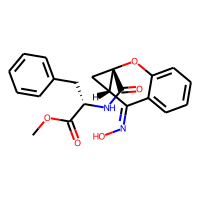
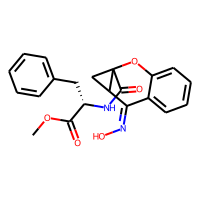
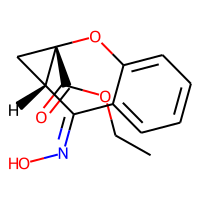
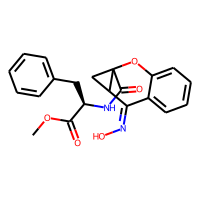
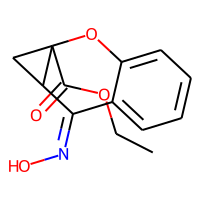
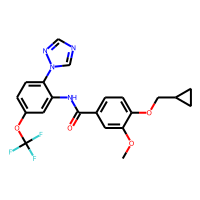
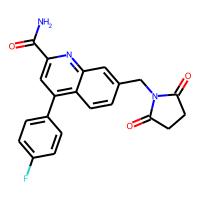
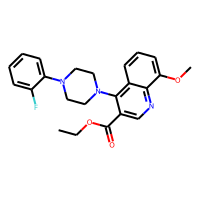
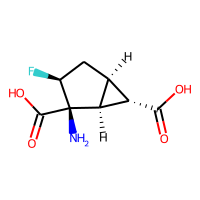
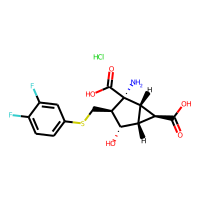

In [25]:
PandasTools.AddMoleculeColumnToFrame(df_combined, smilesCol = 'canonical_smiles',includeFingerprints=True)
df_combined[['molecule_chembl_id','ROMol','canonical_smiles','standard_value', 'class', 'MW','LogP','NumHDonors','NumHAcceptors']]

In [26]:
# Creating custom pIC50()

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:

        # Converts nM to M
        molar = i*(10**-9) 
        
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [27]:
# Noting the min and max values of log
max = -np.log10( (10**-9)* 100000000 )
min = -np.log10( (10**-9)* 10000000000 )
max,min

(1.0, -1.0)

In [28]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,ROMol,standard_value_norm
0,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,active,380.400,1.9165,2.0,6.0,,430.0
1,CHEMBL138082,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,intermediate,380.400,1.9165,2.0,6.0,,1200.0
2,CHEMBL2111945,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,intermediate,247.250,1.5791,1.0,5.0,,1500.0
3,CHEMBL434064,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...,intermediate,380.400,1.9165,2.0,6.0,,1400.0
4,CHEMBL327783,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2,intermediate,247.250,1.5791,1.0,5.0,,3400.0
...,...,...,...,...,...,...,...,...,...
844,CHEMBL4445682,COc1cc(C(=O)Nc2cc(OC(F)(F)F)ccc2-n2cncn2)ccc1O...,inactive,448.401,4.2156,1.0,7.0,,10000.0
845,CHEMBL3892073,NC(=O)c1cc(-c2ccc(F)cc2)c2ccc(CN3C(=O)CCC3=O)c...,inactive,377.375,2.7888,1.0,4.0,,10000.0
846,CHEMBL1527295,CCOC(=O)c1cnc2c(OC)cccc2c1N1CCN(c2ccccc2F)CC1,inactive,409.461,3.8858,0.0,6.0,,30000.0
847,CHEMBL334014,N[C@@]1(C(=O)O)[C@@H](F)C[C@H]2[C@H](C(=O)O)[C...,inactive,203.169,-0.5429,3.0,3.0,,30000.0

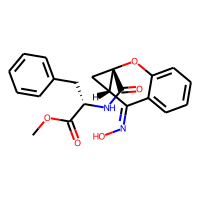
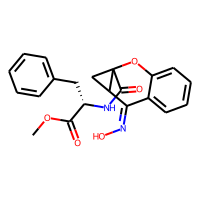
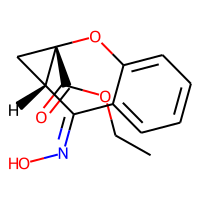
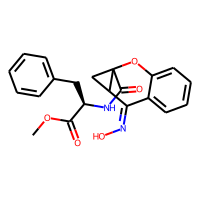
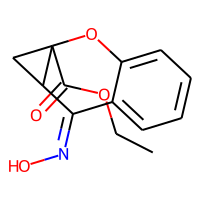
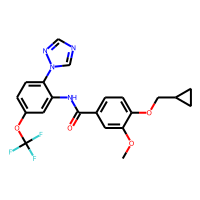
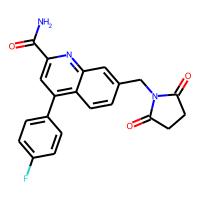
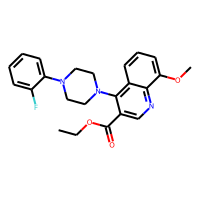
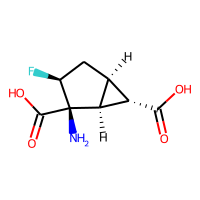
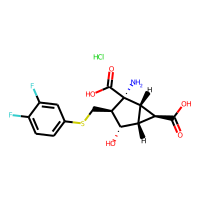

In [29]:
# Calling the function to cap values to 10000000000
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,ROMol,pIC50
0,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,active,380.400,1.9165,2.0,6.0,,6.366532
1,CHEMBL138082,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,intermediate,380.400,1.9165,2.0,6.0,,5.920819
2,CHEMBL2111945,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,intermediate,247.250,1.5791,1.0,5.0,,5.823909
3,CHEMBL434064,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...,intermediate,380.400,1.9165,2.0,6.0,,5.853872
4,CHEMBL327783,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2,intermediate,247.250,1.5791,1.0,5.0,,5.468521
...,...,...,...,...,...,...,...,...,...
844,CHEMBL4445682,COc1cc(C(=O)Nc2cc(OC(F)(F)F)ccc2-n2cncn2)ccc1O...,inactive,448.401,4.2156,1.0,7.0,,5.000000
845,CHEMBL3892073,NC(=O)c1cc(-c2ccc(F)cc2)c2ccc(CN3C(=O)CCC3=O)c...,inactive,377.375,2.7888,1.0,4.0,,5.000000
846,CHEMBL1527295,CCOC(=O)c1cnc2c(OC)cccc2c1N1CCN(c2ccccc2F)CC1,inactive,409.461,3.8858,0.0,6.0,,4.522879
847,CHEMBL334014,N[C@@]1(C(=O)O)[C@@H](F)C[C@H]2[C@H](C(=O)O)[C...,inactive,203.169,-0.5429,3.0,3.0,,4.522879

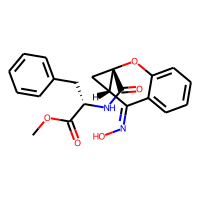
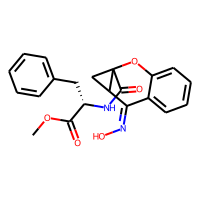
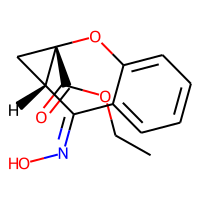
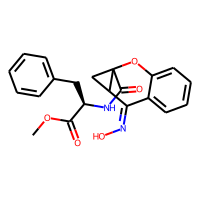
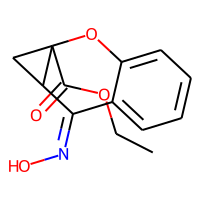
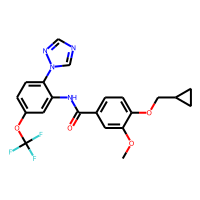
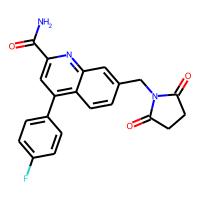
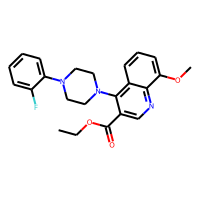
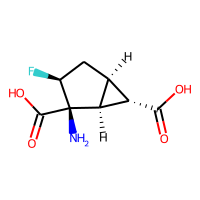
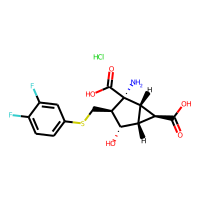

In [30]:
# Converting pIC50 from df
df_final = pIC50(df_norm)
df_final

In [31]:
# Saving to csv file
df_final.to_csv('bioactivity_class_pic50.csv',index=False)



,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,ROMol,pIC50
0,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,active,380.400,1.9165,2.0,6.0,,6.366532
1,CHEMBL138082,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,intermediate,380.400,1.9165,2.0,6.0,,5.920819
2,CHEMBL2111945,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,intermediate,247.250,1.5791,1.0,5.0,,5.823909
3,CHEMBL434064,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...,intermediate,380.400,1.9165,2.0,6.0,,5.853872
4,CHEMBL327783,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2,intermediate,247.250,1.5791,1.0,5.0,,5.468521
...,...,...,...,...,...,...,...,...,...
844,CHEMBL4445682,COc1cc(C(=O)Nc2cc(OC(F)(F)F)ccc2-n2cncn2)ccc1O...,inactive,448.401,4.2156,1.0,7.0,,5.000000
845,CHEMBL3892073,NC(=O)c1cc(-c2ccc(F)cc2)c2ccc(CN3C(=O)CCC3=O)c...,inactive,377.375,2.7888,1.0,4.0,,5.000000
846,CHEMBL1527295,CCOC(=O)c1cnc2c(OC)cccc2c1N1CCN(c2ccccc2F)CC1,inactive,409.461,3.8858,0.0,6.0,,4.522879
847,CHEMBL334014,N[C@@]1(C(=O)O)[C@@H](F)C[C@H]2[C@H](C(=O)O)[C...,inactive,203.169,-0.5429,3.0,3.0,,4.522879

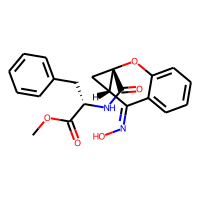
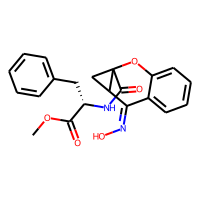
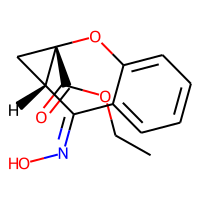
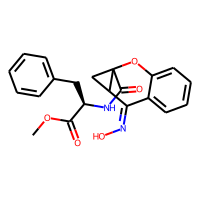
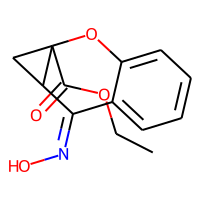
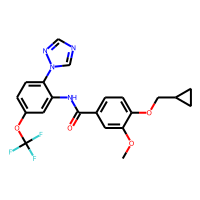
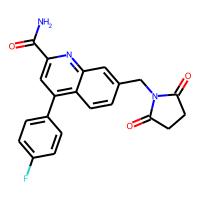
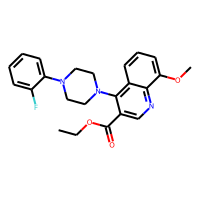
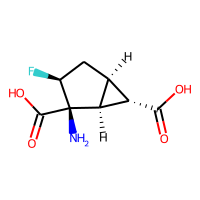
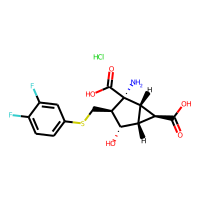

In [32]:
df_final

In [33]:
df = df_final[df_final['class'] != 'intermediate']

In [34]:
df['class'].value_counts()

active      481
inactive    232
Name: class, dtype: int64

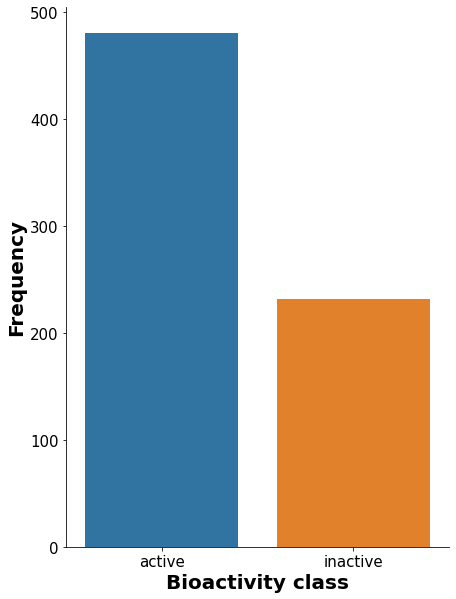

In [35]:
plt.figure(figsize=(6.5, 8.5))

sns.countplot(x='class', data=df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('Frequency', fontsize=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.set(style='ticks')
sns.despine(top=True)
plt.tight_layout()
plt.savefig('plot_bioactivity_class.png')

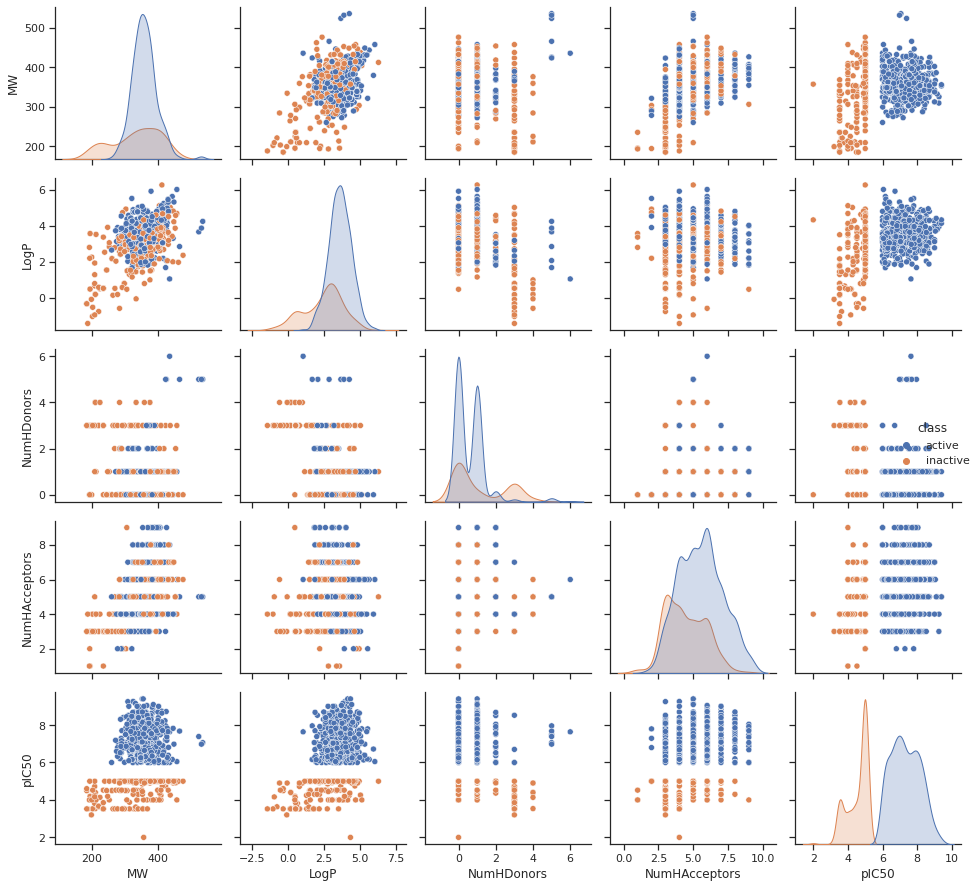

In [36]:
selection = ['class','MW','LogP','NumHDonors','NumHAcceptors','pIC50']
sns.pairplot(df[selection], hue='class')
plt.tight_layout()
plt.savefig('Pairplot.png',dpi=300)

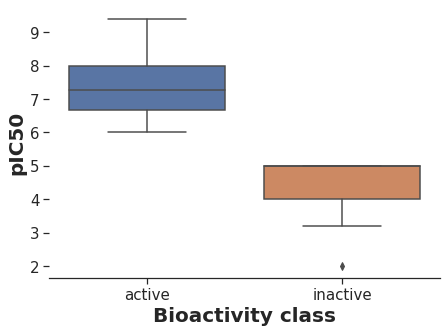

In [37]:
fig = plt.figure(figsize=(7,5))
sns.boxplot(x='class', y='pIC50', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('pIC50', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.despine(top=True, left=True)
plt.savefig('boxplot_pIC50.png',dpi=300);

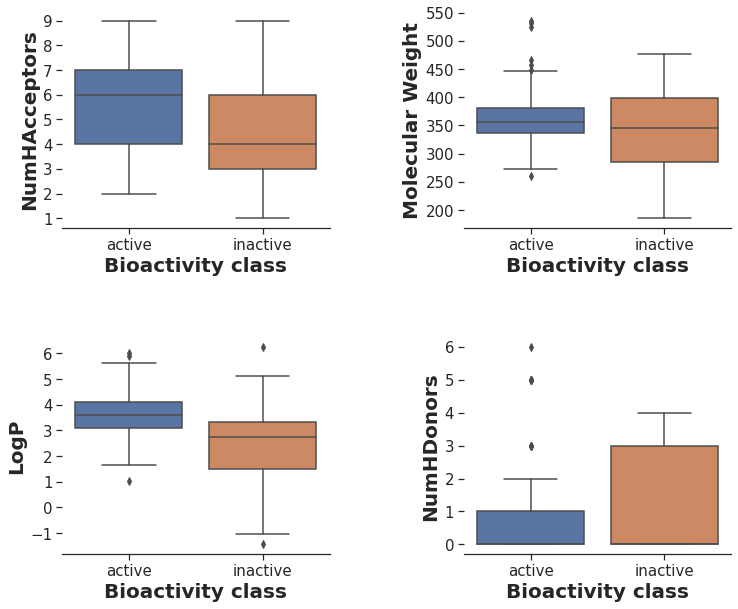

In [38]:
fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
fig.add_subplot(2,2,1)
sns.boxplot(x='class', y='NumHAcceptors', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('NumHAcceptors', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,2)
sns.boxplot(x='class', y='MW', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('Molecular Weight', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,3)
sns.boxplot(x='class', y='LogP', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('LogP', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,4)
sns.boxplot(x='class', y='NumHDonors', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('NumHDonors', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

sns.despine(top=True, left=True)
plt.savefig('boxplot_lipinksi_descriptors.png',dpi=300);

In [39]:
def mannwhitney_(active,inactive, descriptor):
  stat, p = mannwhitneyu(active,inactive)
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [40]:
for feature in selection[1:]: 
    results=mannwhitney_(df[df['class'] != 'inactive'][feature],
                df[df['class'] ==  'inactive'][feature],
                feature)
    display(results)

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,63625.5,0.002379,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,85513.5,9.023909e-31,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,50006.5,0.012853,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,77089.5,4.121630e-17,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,111592.0,1.773536e-104,0.05,Different distribution (reject H0)


In [41]:
df.to_csv('mglur1-data.csv')

In [42]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 23
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
sns.set_style('ticks')

In [43]:
csv_file='mglur1-data.csv'
df = pd.read_csv(csv_file,index_col=0)

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,ROMol,pIC50
0,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,active,380.400,1.9165,2.0,6.0,,6.366532
5,CHEMBL2111943,COC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@]12C[C@@H]1/...,active,380.400,1.9165,2.0,6.0,,6.031517
6,CHEMBL128772,N[C@H](C(=O)O)c1ccc(O)c(C(=O)O)c1,inactive,211.173,0.1748,4.0,4.0,,3.537602
7,CHEMBL299683,CC(N)(C(=O)O)c1ccc(C(=O)O)cc1,inactive,209.201,0.6433,3.0,3.0,,3.809668
8,CHEMBL39372,N[C@H](C(=O)O)c1ccc(C(=O)O)c(O)c1,inactive,211.173,0.1748,4.0,4.0,,4.397940

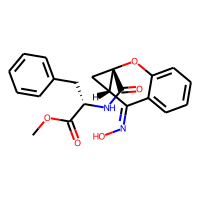
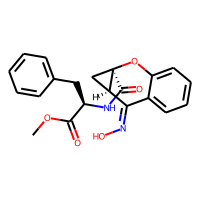
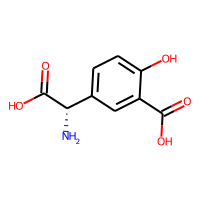
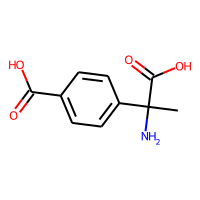
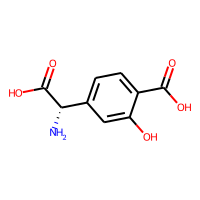

In [44]:
df.head()

In [45]:
print("dimension of diabetes data: {}".format(df.shape))

dimension of diabetes data: (713, 9)


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 0 to 848
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  713 non-null    object 
 1   canonical_smiles    713 non-null    object 
 2   class               713 non-null    object 
 3   MW                  713 non-null    float64
 4   LogP                713 non-null    float64
 5   NumHDonors          713 non-null    float64
 6   NumHAcceptors       713 non-null    float64
 7   ROMol               713 non-null    object 
 8   pIC50               713 non-null    float64
dtypes: float64(5), object(4)
memory usage: 55.7+ KB


In [47]:
selection = ['MW','LogP','NumHDonors','NumHAcceptors','class']
df = df[selection]

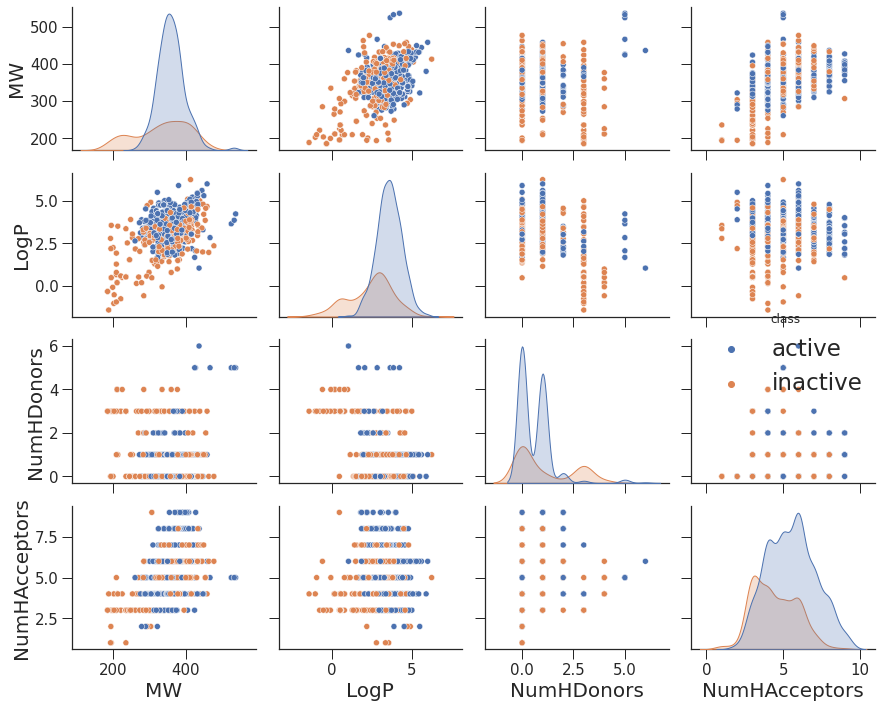

In [48]:
selection = ['class','MW','LogP','NumHDonors','NumHAcceptors']
sns.pairplot(df[selection], hue='class')
plt.tight_layout()

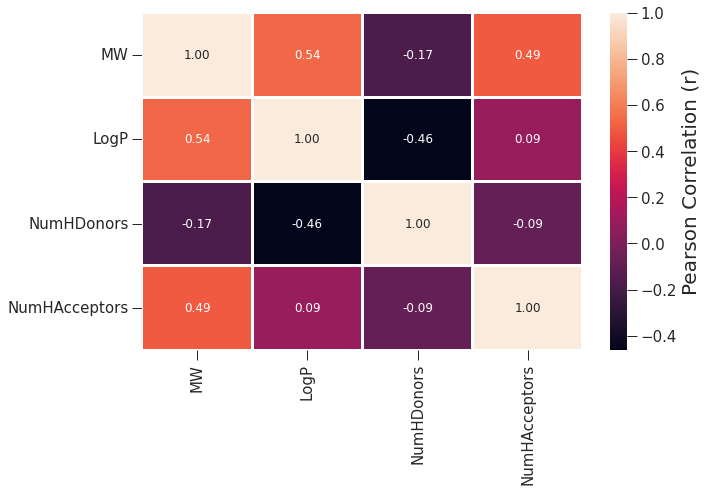

In [49]:
plt.figure(figsize=(10,7))
corr_mat = df.iloc[:,:-1].corr()
sns.heatmap(corr_mat, fmt='0.2f', annot=True, lw=2, cbar_kws={'label':'Pearson Correlation (r)'})
plt.xticks(size=15,rotation=90)
plt.yticks(size=15,rotation=0)
plt.tight_layout()
plt.savefig('Correlation.png',dpi=300);

/home/apolasa/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


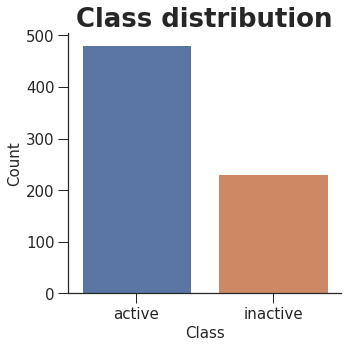

In [50]:
plt.figure(figsize=(5,5))
sns.countplot(df['class'],label='Count')
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Count',size=15)
plt.xlabel('Class',size=15)
sns.despine(top=True)
plt.title('Class distribution',size=26, weight='bold')
plt.tight_layout()
plt.savefig('Class-distribution.png');

In [51]:
df['class'] = df['class'].map({'inactive':0, 'active':1})

In [52]:
X = df.iloc[:,:-1].values   ##features selection
y = df.iloc[:,-1].values    ## target selection

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=27)

In [54]:
rs = SMOTE(sampling_strategy='auto')
X_train,y_train = rs.fit_resample(X_train,y_train)

/home/apolasa/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

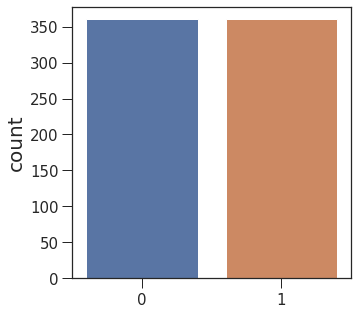

In [55]:
plt.figure(figsize=(5,5))
sns.countplot(y_train)

In [56]:
#k-Nearest Neighbors (KNN)
training_accuracy = [] 
test_accuracy = []
training_f1 = []
test_f1 = []

neighbors_settings = range(2,20)

for n_neighbors in neighbors_settings:
    print(f'working on neighbors {n_neighbors}')
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    y_train_pred=knn.predict(X_train)
    y_pred=knn.predict(X_test)
    
    training_accuracy.append(accuracy_score(y_train,y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_pred))
    
    training_f1.append(f1_score(y_train,y_train_pred))
    test_f1.append(f1_score(y_test, y_pred))
    

working on neighbors 2
working on neighbors 3
working on neighbors 4
working on neighbors 5
working on neighbors 6
working on neighbors 7
working on neighbors 8
working on neighbors 9
working on neighbors 10
working on neighbors 11
working on neighbors 12
working on neighbors 13
working on neighbors 14
working on neighbors 15
working on neighbors 16
working on neighbors 17
working on neighbors 18
working on neighbors 19


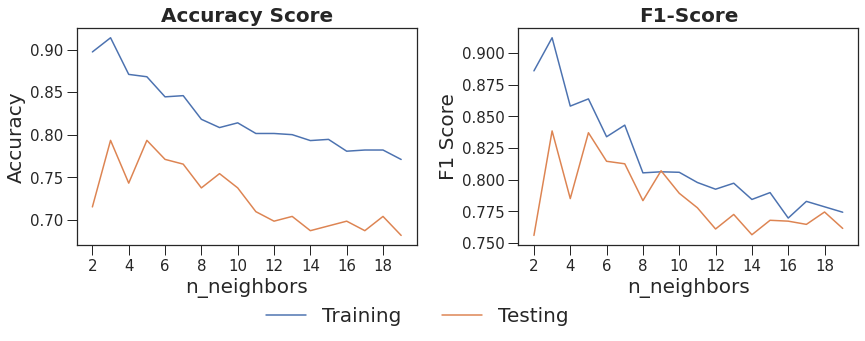

In [57]:
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

fig.add_subplot(2,2,1)
plt.plot(neighbors_settings, training_accuracy, label='training accuracy')
plt.plot(neighbors_settings, test_accuracy, label='test accuracy')
plt.ylabel('Accuracy',size=20)
plt.xticks(range(2,20,2),size=15)
plt.yticks(size=15)
plt.xlabel('n_neighbors',size=20)
plt.title('Accuracy Score',size=20, weight='bold')
plt.legend([],frameon=False, prop={'size':20})

fig.add_subplot(2,2,2)
plt.plot(neighbors_settings, training_f1)
plt.plot(neighbors_settings, test_f1)
plt.xticks(range(2,20,2),size=15)
plt.yticks(size=15)
plt.ylabel('F1 Score',size=20)
plt.xlabel('n_neighbors',size=20)
plt.title('F1-Score',size=20,weight='bold')
plt.legend(['Training','Testing'],frameon=False, bbox_to_anchor=(0.2,-0.2), ncol=2, prop={'size':20});

In [58]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('F1-score of K-NN classifier on test set: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy of K-NN classifier on test set: 0.87
Accuracy of K-NN classifier on test set: 0.79
F1-score of K-NN classifier on test set: 0.84


In [59]:
def normalized_confusion_matrix(y_test, conf_mat, model):
    _ , counts = np.unique(y_test,return_counts=True)
    conf_mat = (conf_mat.T/counts).T
    plt.figure(figsize=(6,5))
    ax=sns.heatmap(conf_mat,fmt='.2f',annot=True,annot_kws={'size':20},lw=2, cbar=True, cbar_kws={'label':'% Class accuracy'})
    plt.title(f'Confusion Matrix ({model})',size=22)
    plt.xticks(size=20)
    plt.yticks(size=20)
    ax.figure.axes[-1].yaxis.label.set_size(20) ##colorbar label
    cax = plt.gcf().axes[-1]  ##colorbar ticks
    cax.tick_params(labelsize=20) ## colorbar ticks
    plt.savefig(f'confusion-matrix-{model}.png',dpi=300)

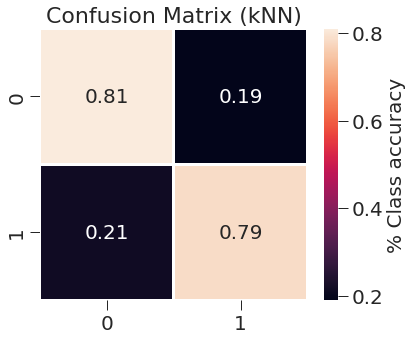

In [60]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat, 'kNN')

In [61]:
k_fold_knn_accuracy = cross_val_score(knn, X, y, cv=10) ##10-fold cross validation
k_fold_knn_f1 = cross_val_score(knn, X, y, cv=10,scoring='f1_weighted') ##10-fold cross validation

In [62]:
print(f'Average accuracy after 10 fold cross validation :{k_fold_knn_accuracy.mean().round(2)} +/- {k_fold_knn_accuracy.std().round(2)}')
print(f'Average F1-score after 10 fold cross validation :{k_fold_knn_f1.mean().round(2)} +/- {k_fold_knn_f1.std().round(2)}')

Average accuracy after 10 fold cross validation :0.72 +/- 0.11
Average F1-score after 10 fold cross validation :0.7 +/- 0.12


In [63]:
#Decision Tree
max_depth=range(1,20)
training_accuracy = [] 
test_accuracy = []
training_f1 = []
test_f1 = []

for depth in max_depth : 
    tree = DecisionTreeClassifier(random_state=0, max_depth=depth, min_samples_leaf=1).fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    y_pred = tree.predict(X_test)
    
    training_accuracy.append(accuracy_score(y_train,y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_pred))
    
    training_f1.append(f1_score(y_train,y_train_pred))
    test_f1.append(f1_score(y_test, y_pred))

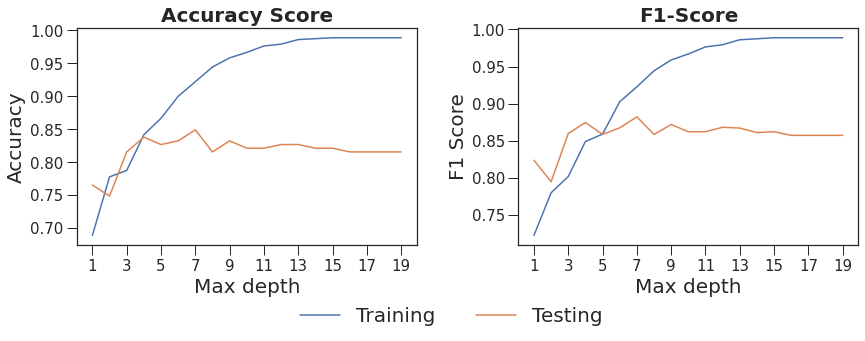

In [64]:
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

fig.add_subplot(2,2,1)
plt.plot(max_depth, training_accuracy, label='training accuracy')
plt.plot(max_depth, test_accuracy, label='test accuracy')
plt.ylabel('Accuracy',size=20)
plt.xlabel('Max depth',size=20)
plt.xticks(range(1,20,2),size=15)
plt.yticks(size=15)
plt.title('Accuracy Score',size=20, weight='bold')
plt.legend([],frameon=False)

fig.add_subplot(2,2,2)
plt.plot(max_depth, training_f1)
plt.plot(max_depth, test_f1)
plt.ylabel('F1 Score',size=20)
plt.xlabel('Max depth',size=20)
plt.xticks(range(1,20,2),size=15)
plt.yticks(size=15)
plt.title('F1-Score',size=20,weight='bold')
plt.legend(['Training','Testing'],frameon=False, bbox_to_anchor=(0.3,-0.2), prop = {'size':20}, ncol=2);

In [65]:
tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1, random_state=0).fit(X_train, y_train)
y_pred=tree.predict(X_test)

print("Accuracy on test: {:.3f}".format(accuracy_score(y_pred, y_test)))
print("F1-score on test set: {:.3f}".format(f1_score(y_pred, y_test)))

Accuracy on test: 0.832
F1-score on test set: 0.872


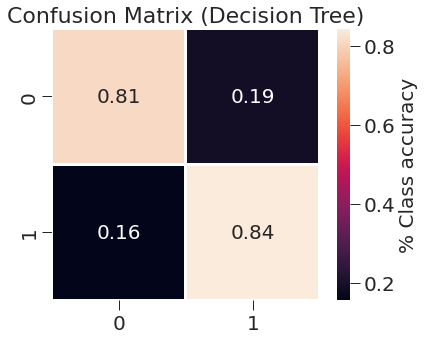

In [66]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat,'Decision Tree')

In [67]:
k_fold_tree_accuracy = cross_val_score(tree, X, y, cv=10) ##10-fold cross validation
k_fold_tree_f1 = cross_val_score(tree, X, y, cv=10, scoring='f1_weighted') ##10-fold cross validation

In [68]:
print(f'Average accuracy after 10 fold cross validation :{k_fold_tree_accuracy.mean().round(2)} +/- {k_fold_tree_accuracy.std().round(2)}')
print(f'Average F1-score after 10 fold cross validation :{k_fold_tree_f1.mean().round(2)} +/- {k_fold_tree_f1.std().round(2)}')

Average accuracy after 10 fold cross validation :0.74 +/- 0.09
Average F1-score after 10 fold cross validation :0.74 +/- 0.09


<Figure size 576x432 with 0 Axes>

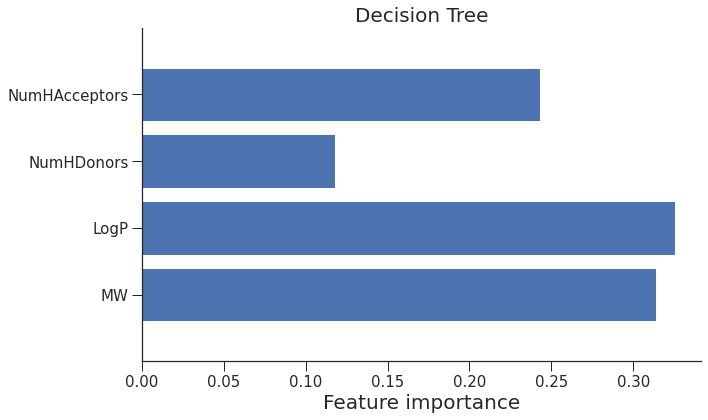

In [69]:
plt.figure(figsize=(8,6))
Clist=[1,0.01,100]

for C in Clist : 

    logreg = LogisticRegression(C=C,solver='newton-cg').fit(X_train, y_train) #keeping C=1 a
    y_train_pred = logreg.predict(X_train)
    y_pred = logreg.predict(X_test)

    
    data_features = [x for i,x in enumerate(df.columns[:-1]) if i!=8]
def plot_feature_importances(model, figure):
    n_features = 4
    plt.figure(figsize=(10,6))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data_features,size=15)
    plt.xticks(size=15)
    plt.xlabel('Feature importance',size=20,)
    #plt.ylabel('Feature',size=20)
    plt.ylim(-1, n_features)
    sns.despine(top=True)
    plt.title(f'{figure}',size=20)
    plt.tight_layout()
    plt.savefig(f'feature-image{figure}.png',dpi=300)

plot_feature_importances(tree,'Decision Tree')

In [70]:
rf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
y_pred=rf.predict(X_test)

print("Accuracy on test: {:.3f}".format(accuracy_score(y_pred, y_test)))
print("F1-score on test set: {:.3f}".format(f1_score(y_pred, y_test)))

Accuracy on test: 0.821
F1-score on test set: 0.867


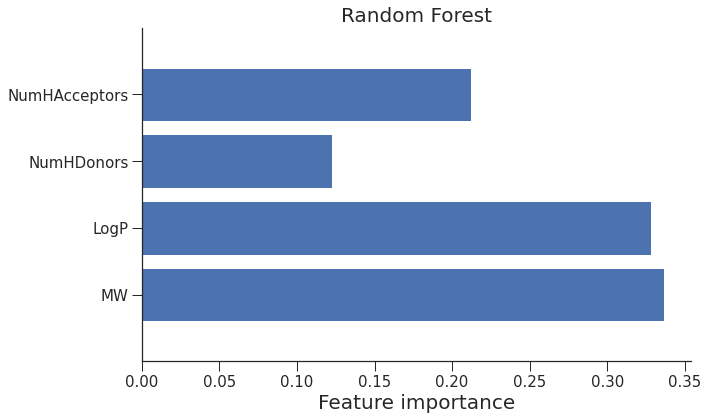

In [71]:
plot_feature_importances(rf, 'Random Forest')

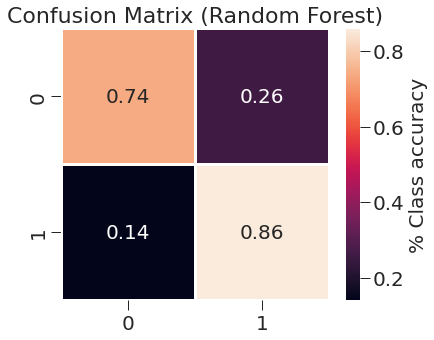

In [72]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat,'Random Forest')

k_fold_rf_accuracy = cross_val_score(rf, X, y, cv=10) ##10-fold cross validation
k_fold_rf_f1 = cross_val_score(rf, X, y, cv=10, scoring='f1_weighted') ##10-fold cross validation

In [73]:
k_fold_rf_accuracy = cross_val_score(rf, X, y, cv=10) ##10-fold cross validation
k_fold_rf_f1 = cross_val_score(rf, X, y, cv=10, scoring='f1_weighted') ##10-fold cross validation

In [74]:
print(f'Average accuracy after 10 fold cross validation :{k_fold_tree_accuracy.mean().round(2)} +/- {k_fold_tree_accuracy.std().round(2)}')
print(f'Average F1-score after 10 fold cross validation :{k_fold_tree_f1.mean().round(2)} +/- {k_fold_tree_f1.std().round(2)}')

Average accuracy after 10 fold cross validation :0.74 +/- 0.09
Average F1-score after 10 fold cross validation :0.74 +/- 0.09


In [75]:
#Support Vector Machine (SVM)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#SVM requiest feature scaling
svc = SVC().fit(X_train_scaled, y_train)
y_pred=svc.predict(X_test_scaled)

print("Accuracy on train: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_pred, y_test)))
print("F1-score on test set: {:.3f}".format(f1_score(y_pred, y_test)))


Accuracy on train: 0.843
Accuracy on test: 0.855
F1-score on test set: 0.885


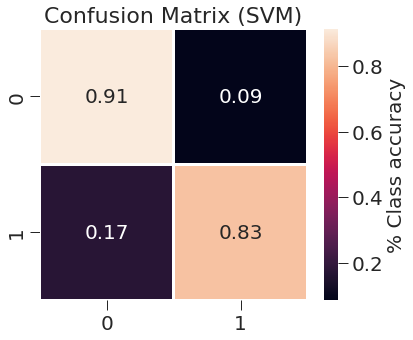

In [76]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat,'SVM')

In [77]:
k_fold_svm_accuracy = cross_val_score(svc, scaler.fit_transform(X), y, cv=10) ##10-fold cross validation
k_fold_svm_f1 = cross_val_score(svc, scaler.fit_transform(X), y, cv=10, scoring='f1_weighted') ##10-fold cross validation

In [78]:
print(f'Average accuracy after 10 fold cross validation : {k_fold_svm_accuracy.mean().round(2)} +/- {k_fold_svm_accuracy.std().round(2)}')
print(f'Average F1-score after 10 fold cross validation : {k_fold_svm_f1.mean().round(2)} +/- {k_fold_svm_f1.std().round(2)}')

Average accuracy after 10 fold cross validation : 0.77 +/- 0.12
Average F1-score after 10 fold cross validation : 0.75 +/- 0.12


In [79]:
all_accuracies = [k_fold_knn_accuracy.mean().round(2),
                   k_fold_tree_accuracy.mean().round(2),
                   k_fold_rf_accuracy.mean().round(2),
                   k_fold_svm_accuracy.mean().round(2),]

all_accuracies_errors = [k_fold_knn_accuracy.std().round(2),
                       k_fold_tree_accuracy.std().round(2),
                       k_fold_rf_accuracy.std().round(2),
                       k_fold_svm_accuracy.std().round(2),]

In [80]:
all_f1 = [k_fold_knn_f1.mean().round(2),
                   k_fold_tree_f1.mean().round(2),
                   k_fold_rf_f1.mean().round(2),
                   k_fold_svm_f1.mean().round(2),]

all_f1_errors = [k_fold_knn_f1.std().round(2),
                   k_fold_tree_f1.std().round(2),
                   k_fold_rf_f1.std().round(2),
                   k_fold_svm_f1.std().round(2),]

In [81]:
models=['kNN','Decision Tree','Random Forest','SVM']

In [82]:
model_data = pd.DataFrame([all_accuracies,all_accuracies_errors,all_f1,all_f1_errors],columns=models, index = ['Accuracy','STD_acc','F1-macro','STD_f1']).T

In [83]:
model_data.style.background_gradient(cmap='coolwarm',axis=0)

,Accuracy,STD_acc,F1-macro,STD_f1
kNN,0.720000,0.110000,0.700000,0.120000
Decision Tree,0.740000,0.090000,0.740000,0.090000
Random Forest,0.750000,0.110000,0.740000,0.110000
SVM,0.770000,0.120000,0.750000,0.120000


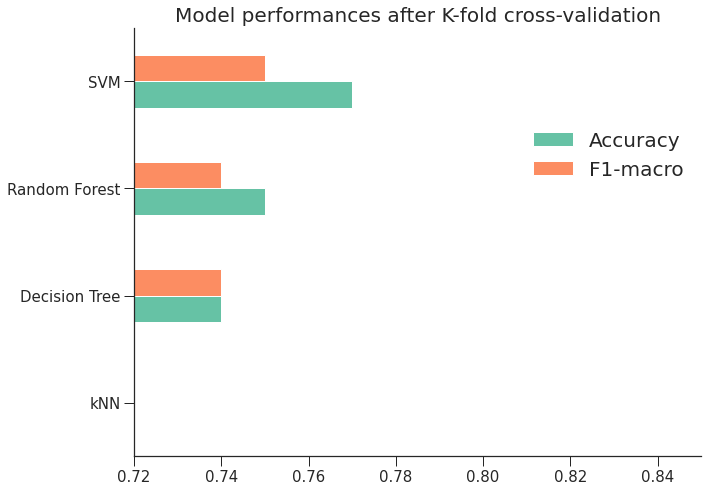

In [84]:
color=sns.color_palette('Set2')
model_data[['Accuracy','F1-macro']].plot.barh(figsize=(10,7),color=color)
plt.legend(frameon=False,bbox_to_anchor=(1,0.8), prop={'size':20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim([0.72,0.85]);
plt.title('Model performances after K-fold cross-validation',size=20)
sns.despine(top=True)
plt.tight_layout()
plt.savefig('model-comparision.png',dpi=300)

In [85]:
#PaDEL-Descriptor
df3 = pd.read_csv('bioactivity_class_pic50.csv')

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,ROMol,pIC50
0,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,active,380.40,1.9165,2.0,6.0,,6.366532
1,CHEMBL138082,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,intermediate,380.40,1.9165,2.0,6.0,,5.920819
2,CHEMBL2111945,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,intermediate,247.25,1.5791,1.0,5.0,,5.823909

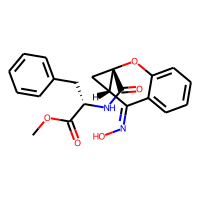
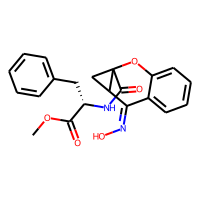
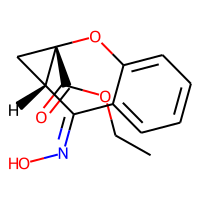

In [86]:
df3.head(3)

In [87]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [88]:
! cat molecule.smi | head -5

COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2	CHEMBL2111944
COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1ccccc1O2	CHEMBL138082
CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2	CHEMBL2111945
COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1ccccc1O2	CHEMBL434064
CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2	CHEMBL327783


In [111]:
! cat molecule.smi | wc -l

849


In [112]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [113]:
! bash padel.sh

Processing CHEMBL2111944 in molecule.smi (1/849). 
Processing CHEMBL138082 in molecule.smi (2/849). 
Processing CHEMBL2111945 in molecule.smi (3/849). 
Processing CHEMBL434064 in molecule.smi (4/849). 
Processing CHEMBL327783 in molecule.smi (5/849). 
Processing CHEMBL2111943 in molecule.smi (6/849). 
Processing CHEMBL128772 in molecule.smi (7/849). 
Processing CHEMBL39372 in molecule.smi (9/849). 
Processing CHEMBL299683 in molecule.smi (8/849). 
Processing CHEMBL313938 in molecule.smi (10/849). 
Processing CHEMBL94990 in molecule.smi (11/849). 
Processing CHEMBL328984 in molecule.smi (12/849). 
Processing CHEMBL444589 in molecule.smi (13/849). 
Processing CHEMBL39338 in molecule.smi (14/849). 
Processing CHEMBL97574 in molecule.smi (16/849). 
Processing CHEMBL420262 in molecule.smi (17/849). 
Processing CHEMBL40123 in molecule.smi (15/849). 
Processing CHEMBL319279 in molecule.smi (18/849). 
Processing CHEMBL439775 in molecule.smi (19/849). 
Processing CHEMBL99462 in molecule.smi (20

Processing CHEMBL225590 in molecule.smi (121/849). Average speed: 0.41 s/mol.
Processing CHEMBL225589 in molecule.smi (122/849). Average speed: 0.40 s/mol.
Processing CHEMBL225124 in molecule.smi (123/849). Average speed: 0.40 s/mol.
Processing CHEMBL389897 in molecule.smi (124/849). Average speed: 0.40 s/mol.
Processing CHEMBL374135 in molecule.smi (125/849). Average speed: 0.40 s/mol.
Processing CHEMBL387687 in molecule.smi (126/849). Average speed: 0.40 s/mol.
Processing CHEMBL225439 in molecule.smi (127/849). Average speed: 0.39 s/mol.
Processing CHEMBL374167 in molecule.smi (128/849). Average speed: 0.39 s/mol.
Processing CHEMBL426018 in molecule.smi (129/849). Average speed: 0.39 s/mol.
Processing CHEMBL224615 in molecule.smi (130/849). Average speed: 0.39 s/mol.
Processing CHEMBL223868 in molecule.smi (131/849). Average speed: 0.39 s/mol.
Processing CHEMBL386935 in molecule.smi (132/849). Average speed: 0.39 s/mol.
Processing CHEMBL223819 in molecule.smi (133/849). Average speed

Processing CHEMBL460391 in molecule.smi (227/849). Average speed: 0.34 s/mol.
Processing CHEMBL460827 in molecule.smi (228/849). Average speed: 0.34 s/mol.
Processing CHEMBL511352 in molecule.smi (229/849). Average speed: 0.34 s/mol.
Processing CHEMBL461033 in molecule.smi (230/849). Average speed: 0.34 s/mol.
Processing CHEMBL461034 in molecule.smi (231/849). Average speed: 0.33 s/mol.
Processing CHEMBL461035 in molecule.smi (232/849). Average speed: 0.33 s/mol.
Processing CHEMBL457872 in molecule.smi (233/849). Average speed: 0.33 s/mol.
Processing CHEMBL453249 in molecule.smi (234/849). Average speed: 0.33 s/mol.
Processing CHEMBL457873 in molecule.smi (235/849). Average speed: 0.33 s/mol.
Processing CHEMBL452618 in molecule.smi (236/849). Average speed: 0.33 s/mol.
Processing CHEMBL456823 in molecule.smi (237/849). Average speed: 0.34 s/mol.
Processing CHEMBL457026 in molecule.smi (238/849). Average speed: 0.34 s/mol.
Processing CHEMBL456196 in molecule.smi (239/849). Average speed

Processing CHEMBL1783861 in molecule.smi (332/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783862 in molecule.smi (333/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783863 in molecule.smi (334/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783864 in molecule.smi (335/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783865 in molecule.smi (336/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783866 in molecule.smi (337/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783867 in molecule.smi (338/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783868 in molecule.smi (339/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783869 in molecule.smi (340/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783870 in molecule.smi (341/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783871 in molecule.smi (342/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783872 in molecule.smi (343/849). Average speed: 0.32 s/mol.
Processing CHEMBL1783873 in molecule.smi (344/849). 

Processing CHEMBL2205369 in molecule.smi (436/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205368 in molecule.smi (437/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205367 in molecule.smi (438/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205366 in molecule.smi (439/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205365 in molecule.smi (440/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205364 in molecule.smi (441/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205363 in molecule.smi (442/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205919 in molecule.smi (443/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205918 in molecule.smi (444/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205917 in molecule.smi (445/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205916 in molecule.smi (446/849). Average speed: 0.31 s/mol.
Processing CHEMBL2205915 in molecule.smi (447/849). Average speed: 0.32 s/mol.
Processing CHEMBL2205914 in molecule.smi (448/849). 

Processing CHEMBL2418355 in molecule.smi (540/849). Average speed: 0.31 s/mol.
Processing CHEMBL2418385 in molecule.smi (541/849). Average speed: 0.31 s/mol.
Processing CHEMBL2418384 in molecule.smi (542/849). Average speed: 0.31 s/mol.
Processing CHEMBL2418383 in molecule.smi (543/849). Average speed: 0.31 s/mol.
Processing CHEMBL2418382 in molecule.smi (544/849). Average speed: 0.31 s/mol.
Processing CHEMBL2418381 in molecule.smi (545/849). Average speed: 0.31 s/mol.
Processing CHEMBL2418380 in molecule.smi (546/849). Average speed: 0.31 s/mol.
Processing CHEMBL2418379 in molecule.smi (547/849). Average speed: 0.31 s/mol.
Processing CHEMBL2418378 in molecule.smi (548/849). Average speed: 0.31 s/mol.
Processing CHEMBL2418377 in molecule.smi (549/849). Average speed: 0.31 s/mol.
Processing CHEMBL2418376 in molecule.smi (550/849). Average speed: 0.32 s/mol.
Processing CHEMBL2418375 in molecule.smi (551/849). Average speed: 0.32 s/mol.
Processing CHEMBL2418374 in molecule.smi (552/849). 

Processing CHEMBL3634447 in molecule.smi (644/849). Average speed: 0.32 s/mol.
Processing CHEMBL3634448 in molecule.smi (645/849). Average speed: 0.32 s/mol.
Processing CHEMBL3634449 in molecule.smi (646/849). Average speed: 0.32 s/mol.
Processing CHEMBL3634450 in molecule.smi (647/849). Average speed: 0.32 s/mol.
Processing CHEMBL3634451 in molecule.smi (648/849). Average speed: 0.32 s/mol.
Processing CHEMBL3786530 in molecule.smi (649/849). Average speed: 0.32 s/mol.
Processing CHEMBL3947221 in molecule.smi (650/849). Average speed: 0.32 s/mol.
Processing CHEMBL3899832 in molecule.smi (651/849). Average speed: 0.32 s/mol.
Processing CHEMBL3644416 in molecule.smi (652/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702357 in molecule.smi (653/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702358 in molecule.smi (654/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702359 in molecule.smi (655/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702360 in molecule.smi (656/849). 

Processing CHEMBL3644419 in molecule.smi (748/849). Average speed: 0.32 s/mol.
Processing CHEMBL3644420 in molecule.smi (749/849). Average speed: 0.32 s/mol.
Processing CHEMBL3644421 in molecule.smi (750/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702454 in molecule.smi (751/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702455 in molecule.smi (752/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702456 in molecule.smi (753/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702457 in molecule.smi (754/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702458 in molecule.smi (755/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702459 in molecule.smi (756/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702460 in molecule.smi (757/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702461 in molecule.smi (758/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702462 in molecule.smi (759/849). Average speed: 0.32 s/mol.
Processing CHEMBL3702463 in molecule.smi (760/849). 

In [114]:
df3_X = pd.read_csv('descriptors_output.csv')
df3_X = df3_X.drop(columns=['Name'])

In [115]:
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
845,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
846,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
847,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [116]:
df3_y=df3['pIC50']
df3_y

0      6.366532
1      5.920819
2      5.823909
3      5.853872
4      5.468521
         ...   
844    5.000000
845    5.000000
846    4.522879
847    4.522879
848    4.903090
Name: pIC50, Length: 849, dtype: float64

In [117]:
dataset3=pd.concat([df3_X,df3_y],axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.366532
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.920819
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.823909
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.853872
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.468521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000
845,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000
846,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.522879
847,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.522879


In [118]:
dataset3.to_csv('mglur1_pIC50_pubchem_fp.csv', index=False)

In [119]:
df=pd.read_csv('mglur1_pIC50_pubchem_fp.csv')

In [120]:
df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.366532
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.920819
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.823909
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.853872
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.468521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000
845,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000
846,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.522879
847,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.522879


In [121]:
X=df.drop(columns=['pIC50'])

In [122]:
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
845,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
846,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
847,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [123]:
y=df['pIC50']
y

0      6.366532
1      5.920819
2      5.823909
3      5.853872
4      5.468521
         ...   
844    5.000000
845    5.000000
846    4.522879
847    4.522879
848    4.903090
Name: pIC50, Length: 849, dtype: float64

In [124]:
X.shape

(849, 881)

In [125]:
y.shape

(849,)

In [126]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [127]:
X.shape

(849, 152)

In [128]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

In [129]:
X_train.shape,y_train.shape

((636, 152), (636,))

In [130]:
X_test.shape, y_test.shape

((213, 152), (213,))

In [131]:
from sklearn.ensemble import RandomForestRegressor

In [132]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [133]:
print("Coefficient of determination R^2 <-- on train set: {}".format(model.score(X_train, y_train)))

Coefficient of determination R^2 <-- on train set: 0.8552754059354557


In [134]:
print("Coefficient of determination R^2 <-- on train set: {}".format(model.score(X_test, y_test)))

Coefficient of determination R^2 <-- on train set: 0.5369760759636864


In [135]:
Y_pred = model.predict(X_test)

/home/apolasa/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

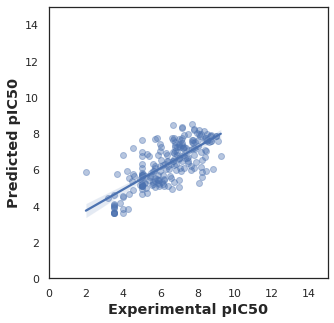

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)
ax.figure.set_size_inches(5, 5)
plt.show

In [137]:
#Autodock 
selection = ['molecule_chembl_id','canonical_smiles','ROMol']
df3_selection = df3[selection]

,molecule_chembl_id,canonical_smiles,ROMol
0,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,
1,CHEMBL138082,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,
2,CHEMBL2111945,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,
3,CHEMBL434064,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...,
4,CHEMBL327783,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2,
5,CHEMBL2111943,COC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@]12C[C@@H]1/...,
6,CHEMBL128772,N[C@H](C(=O)O)c1ccc(O)c(C(=O)O)c1,
7,CHEMBL299683,CC(N)(C(=O)O)c1ccc(C(=O)O)cc1,
8,CHEMBL39372,N[C@H](C(=O)O)c1ccc(C(=O)O)c(O)c1,
9,CHEMBL313938,NC1(C(=O)O)CCc2cc(C(=O)O)ccc21,

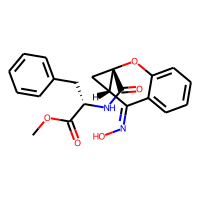
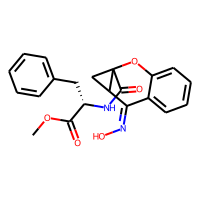
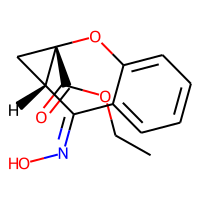
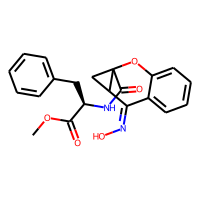
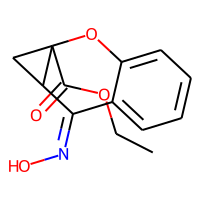
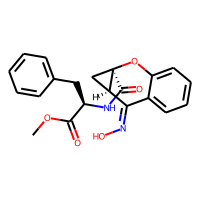
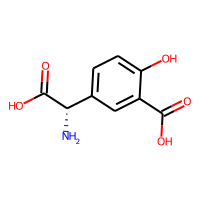
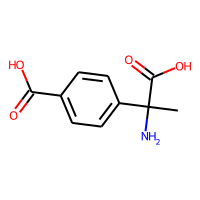
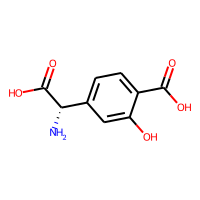
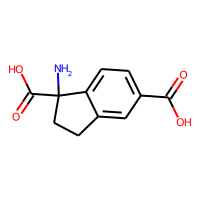

In [138]:
df3_selection.head(10)

In [139]:
df=pd.read_csv('results1.dat')

In [140]:
df

,score
0,-12.5
1,-8.2
2,-7.7
3,-10.4
4,-8.3
5,-8.1
6,-7.9
7,-7.9
8,-10.2
9,-8.8


,molecule_chembl_id,canonical_smiles,ROMol,score
0,CHEMBL2111944,COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@]12C[C@H]1/C(=...,,-12.5
1,CHEMBL138082,COC(=O)[C@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1c...,,-8.2
2,CHEMBL2111945,CCOC(=O)[C@]12C[C@H]1/C(=N\O)c1ccccc1O2,,-7.7
3,CHEMBL434064,COC(=O)[C@@H](Cc1ccccc1)NC(=O)C12CC1/C(=N\O)c1...,,-10.4
4,CHEMBL327783,CCOC(=O)C12CC1/C(=N\O)c1ccccc1O2,,-8.3
5,CHEMBL2111943,COC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@]12C[C@@H]1/...,,-8.1
6,CHEMBL128772,N[C@H](C(=O)O)c1ccc(O)c(C(=O)O)c1,,-7.9
7,CHEMBL299683,CC(N)(C(=O)O)c1ccc(C(=O)O)cc1,,-7.9
8,CHEMBL39372,N[C@H](C(=O)O)c1ccc(C(=O)O)c(O)c1,,-10.2
9,CHEMBL313938,NC1(C(=O)O)CCc2cc(C(=O)O)ccc21,,-8.8

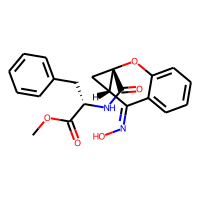
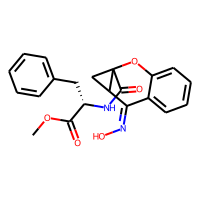
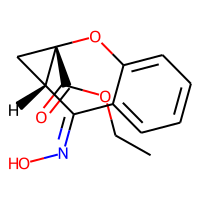
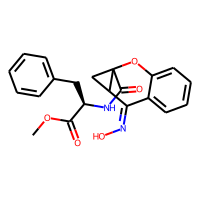
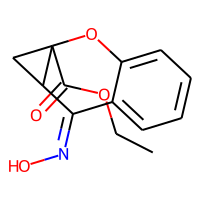
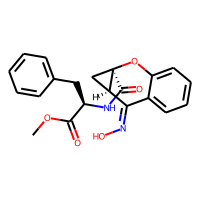
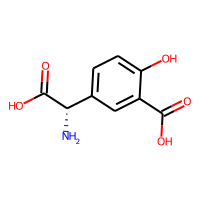
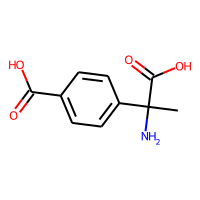
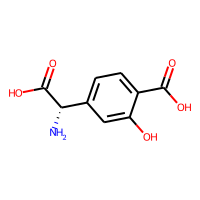
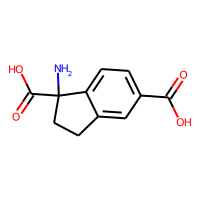

In [141]:
# Combining the two columns
df_combined_Autodock = pd.concat([df3_selection.head(10),df],axis=1)
df_combined_Autodock

In [ ]:
sorted_df = df_combined_Autodock.sort_values(by=["score"], ascending=True)

In [ ]:
sorted_df

In [ ]:
sorted_df.to_csv('mgkur1_Top_10_docking_scores.csv', index=False)